# Bayesian Computation

This jupyter notebook accompanies the Bayesian Shenaniganry lecture(s) delivered by Justin Alsing and Stephen Feeney as part of [Astro Hack Week 2019](http://astrohackweek.org/2019/). As part of the lecture(s) you will be asked to complete a number of tasks, some of which will involve direct coding into the notebook; these sections are marked by task. This notebook requires numpy, matplotlib, scipy, [corner](https://corner.readthedocs.io/en/latest/), [pystan](https://pystan.readthedocs.io/en/latest/getting_started.html) and pickle to run (the last two are required solely for the final task). If you don't have these packages fret not: the notebook can be run on [Google Colab](https://colab.research.google.com/github/sfeeney/ahw19/blob/master/ahw_complete.ipynb).

We start with imports...

In [1]:
from __future__ import print_function

# make sure everything we need is installed if running on Google Colab
def is_colab():
    try:
        cfg = get_ipython().config
        if cfg['IPKernelApp']['kernel_class'] == 'google.colab._kernel.Kernel':
            return True
        else:
            return False
    except NameError:
        return False
if is_colab():
    !pip install --quiet numpy matplotlib scipy corner pystan emcee

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as mp
import scipy.stats as sps
%matplotlib inline

## Task 1

Write a Python function simulating a very simple linear process observed at known positions $x$ with Gaussian measurement noise: $\hat{y} = m x + c + n$, where $n \sim N(0, \sigma^2)$.

In [2]:
# prior settings
mu_slope = 1.0
sig_slope = 0.1
mu_intcpt = 0.0
sig_intcpt = 0.05
mu_var_noise = 0.02
var_var_noise = mu_var_noise ** 2 / 9.0
shape_var_noise = mu_var_noise ** 2 / var_var_noise + 2.0
scale_var_noise = mu_var_noise * (mu_var_noise ** 2 / var_var_noise + 1.0)

# super-simple wrapper
def x_grid(n_x, x_min=0.0, x_max=1.0):
    
    return np.linspace(x_min, x_max, n_x)

# draw sample from parameter prior
def sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    
    pars = np.zeros(2)
    pars[0] = npr.normal(mu_slope, sig_slope)
    pars[1] = npr.normal(mu_intcpt, sig_intcpt)
    
    return pars

# generate noisy data given parameters
def sample_data(x, pars, var_noise):
    
    y = pars[0] * x + pars[1] + npr.normal(0.0, np.sqrt(var_noise), len(x))
    
    return y

# most basic simulator function: noisy measurements at known locations
def simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, var_noise):
    
    # draw parameters from prior
    pars = sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt)
    
    # generate data
    y = sample_data(x, pars, var_noise)
    
    return [pars, y]

Let's put together some quick checks that everything's working as planned. First, plot some draws from the prior...

parameter means & standard deviations
* m
  reals:   0.9997381057368014 0.10022023960568135
  theory:  1.0 0.1
* c
  reals:   -0.00010484084775924596 0.05045931703642392
  theory:  0.0 0.05


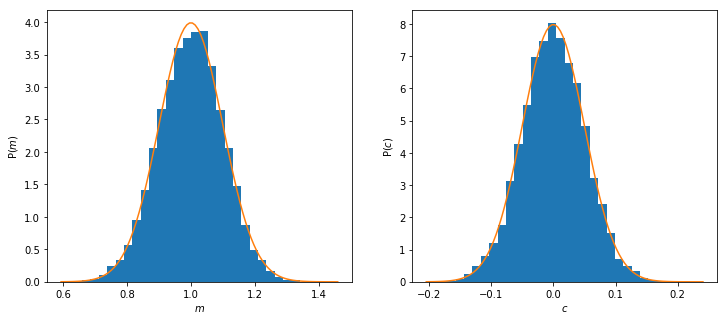

In [3]:
# lots of draws from priors
pars = []
for i in range(10000):
    pars.append(sample_prior(mu_slope, sig_slope, mu_intcpt, sig_intcpt))
pars = np.array(pars)
par_names = [r'm', r'c']

# plot versus expectations
print('parameter means & standard deviations')
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    print('*', par_names[i])
    print('  reals:  ', np.mean(pars[:, i]), np.std(pars[:, i]))
    _ = axes[i].hist(pars[:, i], bins=30, density=True)
    par_lims = axes[i].get_xlim()
    par_grid = np.linspace(par_lims[0], par_lims[1], 100)
    axes[i].set_xlabel('$' + par_names[i] + '$')
    axes[i].set_ylabel(r'${\rm P(}' + par_names[i] + ')$')
    if i == 0:
        print('  theory: ', mu_slope, sig_slope)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_slope, sig_slope))
    elif i == 1:
        print('  theory: ', mu_intcpt, sig_intcpt)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_intcpt, sig_intcpt))

... and now some simulated data to check the noise distribution.

noise mean & standard deviation
  reals:   -0.0015343507652491655 0.14089150587102525
  theory:  0.0 0.1414213562373095


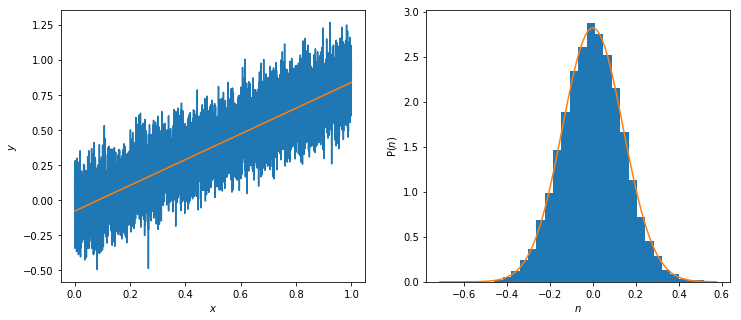

In [4]:
# draw a large data realization with fixed noise variance
x = x_grid(10000)
pars, y = simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, mu_var_noise)
noise = y - (pars[0] * x + pars[1])

# plot noise histogram versus expectation
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, y)
axes[0].plot(x, pars[0] * x + pars[1])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
_ = axes[1].hist(noise, bins=30, density=True)
par_lims = axes[1].get_xlim()
par_grid = np.linspace(par_lims[0], par_lims[1], 100)
axes[1].plot(par_grid, sps.norm.pdf(par_grid, 0.0, np.sqrt(mu_var_noise)))
axes[1].set_xlabel('$n$')
axes[1].set_ylabel(r'${\rm P(}n)$')
print('noise mean & standard deviation')
print('  reals:  ', np.mean(noise), np.std(noise))
print('  theory: ', 0.0, np.sqrt(mu_var_noise))

## Task 2

Code up the gridded posterior. Let's split this into two parts. First, write three functions evaluating the log-likelihood, log-prior and log-posterior for a set of sampled parameters. These will be very useful in the future.

In [5]:
def ln_like(pars, x, y, var_noise):
    
    delta = y - (pars[0] * x + pars[1])
    cinv = np.diag(np.ones(len(x)) / var_noise)
    ln_like_y = -0.5 * np.dot(np.dot(delta, cinv), delta)
        
    return ln_like_y

def ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return -0.5 * (((pars[0] - mu_slope) / sig_slope) ** 2 + ((pars[1] - mu_intcpt) / sig_intcpt) ** 2)

def ln_post(pars, x, y, var_noise, mu_slope, sig_slope, mu_intcpt, sig_intcpt):
    return ln_like(pars, x, y, var_noise) + \
           ln_prior(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt)

Now evaluate the posterior on a grid of parameters...

In [6]:
# generate a smaller data realization
x = x_grid(100)
pars, y = simulator(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, mu_var_noise)

# and calculate its parameter posterior on a grid
n_grid = 300
slope_grid = np.linspace(mu_slope - 3.0 * sig_slope, mu_slope + 3.0 * sig_slope, n_grid)
intcpt_grid = np.linspace(mu_intcpt - 3.0 * sig_intcpt, mu_intcpt + 3.0 * sig_intcpt, n_grid)
post = np.zeros((n_grid, n_grid))
for i in range(n_grid):
    for j in range(n_grid):
        post[i, j] = np.exp(ln_post([slope_grid[i], intcpt_grid[j]], x, y, mu_var_noise, mu_slope, \
                                    sig_slope, mu_intcpt, sig_intcpt))

... and plot the joint posterior and the two one-dimensional marginal distributions.

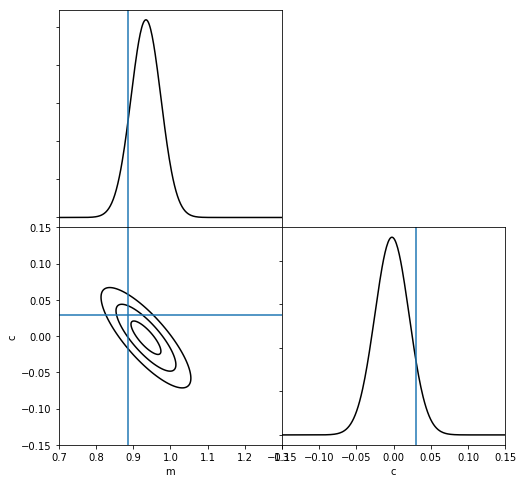

In [7]:
# calculate marginal posteriors
post_slope = np.sum(post, axis=1)
post_intcpt = np.sum(post, axis=0)

# plot joint and marginal posteriors
fig, axes = mp.subplots(2, 2, figsize=(8, 8))
levels = np.array([0.011109, 0.13533528, 0.60653066]) * np.max(post)
axes[0, 0].plot(slope_grid, post_slope, color='k')
axes[1, 1].plot(intcpt_grid, post_intcpt, color='k')
axes[1, 0].contour(slope_grid, intcpt_grid, post.T, levels=levels, colors='k')

# prettify
axes[0, 0].axvline(pars[0])
axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])
axes[0, 0].set_xlim(axes[1, 0].get_xlim())
axes[1, 0].axvline(pars[0])
axes[1, 0].axhline(pars[1])
axes[1, 0].set_xlabel(par_names[0])
axes[1, 0].set_ylabel(par_names[1])
axes[1, 1].set_xlim(axes[1, 0].get_ylim())
axes[1, 1].axvline(pars[1])
axes[1, 1].set_yticklabels([])
axes[1, 1].set_xlabel(par_names[1])
fig.delaxes(axes[0, 1])
fig.subplots_adjust(hspace=0, wspace=0)

A useful way of summarizing the plots above is to determine the highest density region. One can do this by sorting each marginal probability array in decreasing order and finding the index at which the cumulative sum exceeds the desired threshold (e.g., 68%). The preceding indices define the highest density region: its limits in parameter space are a credible interval for the parameter of interest.

In [8]:
# a very hacky way to find highest density region
def cred_int(par, post, threshold):
    
    # sort the posterior and parameter arrays in order of decreasing probability
    ind_sort = np.argsort(-post)
    par_sort = par[ind_sort]
    post_sort = post[ind_sort]
    
    # form the cumulative sum of the sorted posterior array, rescale from 0->1 
    # and find the indices for whom the cumsum is less than the desired threshold
    post_sort_cs = np.cumsum(post_sort) / np.sum(post)
    ind_cred_int = post_sort_cs <= threshold
    
    # use these indices and the sorted parameter array to find the parameter values in
    # the credible interval. the extremes of these values define the credible interval
    par_in_cred_int = par_sort[ind_cred_int]
    
    return np.array([np.min(par_in_cred_int), np.max(par_in_cred_int)])

print(cred_int(slope_grid, post_slope, 0.68))
print(cred_int(intcpt_grid, post_intcpt, 0.68))

[0.89665552 0.9729097 ]
[-0.02458194  0.01956522]


## Task 3

First complicate the simulator so that we draw a random noise variance (which we now want to infer from the data) along with the other parameters.

In [9]:
# draw sample from parameter prior
def sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    pars = np.zeros(3)
    pars[0] = npr.normal(mu_slope, sig_slope)
    pars[1] = npr.normal(mu_intcpt, sig_intcpt)
    pars[2] = 1.0 / npr.gamma(shape_var_noise, 1.0 / scale_var_noise)
    
    return pars

# generate noisy data given parameters
def sample_data_nv(x, pars):
    
    y = pars[0] * x + pars[1] + npr.normal(0.0, np.sqrt(pars[2]), len(x))
    
    return y

# more advanced simulator function: noisy measurements at known locations with unknown noise variance
def simulator_nv(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    # draw parameters from prior
    pars = sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise)
    
    # generate data
    y = sample_data_nv(x, pars)
    
    return [pars, y]

As before, let's quickly check we're drawing parameters correctly from the prior...

parameter means & standard deviations
* m
  reals:   1.0007539942837762 0.10140029471469422
  theory:  1.0 0.1
* c
  reals:   -0.0003406673788093014 0.05040249375615994
  theory:  0.0 0.05
* \sigma_{\rm noise}^2
  reals:   0.019978816087862075 0.0066723332908264045
  theory:  0.02 0.006666666666666667


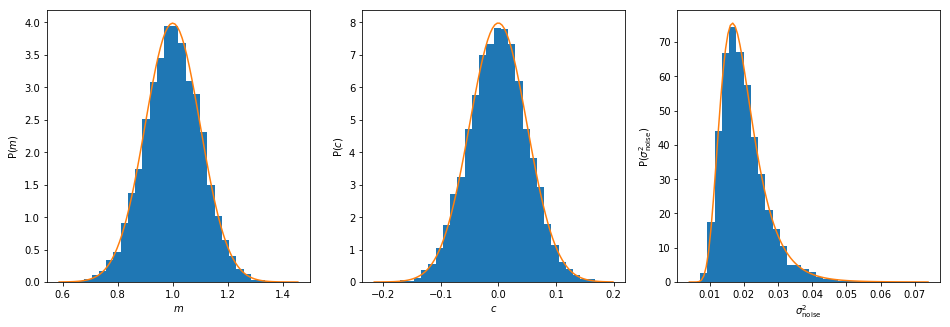

In [10]:
# draw from priors
pars = []
for i in range(10000):
    pars.append(sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise))
pars = np.array(pars)
par_names_nv = [r'm', r'c', r'\sigma_{\rm noise}^2']

# plot versus expectations
print('parameter means & standard deviations')
fig, axes = mp.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    print('*', par_names_nv[i])
    print('  reals:  ', np.mean(pars[:, i]), np.std(pars[:, i]))
    _ = axes[i].hist(pars[:, i], bins=30, density=True)
    par_lims = axes[i].get_xlim()
    par_grid = np.linspace(par_lims[0], par_lims[1], 100)
    axes[i].set_xlabel('$' + par_names_nv[i] + '$')
    axes[i].set_ylabel(r'${\rm P(}' + par_names_nv[i] + ')$')
    if i == 0:
        print('  theory: ', mu_slope, sig_slope)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_slope, sig_slope))
    elif i == 1:
        print('  theory: ', mu_intcpt, sig_intcpt)
        axes[i].plot(par_grid, sps.norm.pdf(par_grid, mu_intcpt, sig_intcpt))
    elif i == 2:
        print('  theory: ', mu_var_noise, np.sqrt(var_var_noise))
        axes[i].plot(par_grid, sps.invgamma.pdf(par_grid, shape_var_noise, scale=scale_var_noise))

... and generating data realisations with the right noise.

noise mean & standard deviation
  reals:   -0.002653018545459117 0.14375010651080725
  theory:  0.0 0.14408033472372003


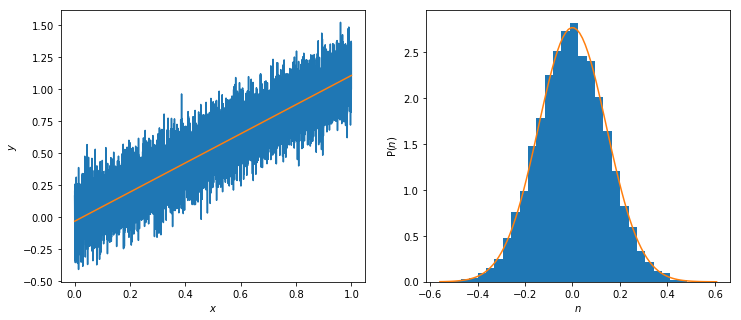

In [11]:
# draw a large data realization with fixed noise variance
x = x_grid(10000)
pars, y = simulator_nv(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise)
noise = y - (pars[0] * x + pars[1])

# plot noise histogram versus expectation
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, y)
axes[0].plot(x, pars[0] * x + pars[1])
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
_ = axes[1].hist(noise, bins=30, density=True)
par_lims = axes[1].get_xlim()
par_grid = np.linspace(par_lims[0], par_lims[1], 100)
axes[1].plot(par_grid, sps.norm.pdf(par_grid, 0.0, np.sqrt(pars[2])))
axes[1].set_xlabel('$n$')
axes[1].set_ylabel(r'${\rm P(}n)$')
print('noise mean & standard deviation')
print('  reals:  ', np.mean(noise), np.std(noise))
print('  theory: ', 0.0, np.sqrt(pars[2]))

The Metropolis-Hastings algorithm is a particularly simple and hence extremely broadly employed Markov-Chain Monte Carlo (MCMC) technique for obtaining samples from a posterior. All this algorithm requires is the ability to evaluate the posterior at any point in parameter space (up to any parameter-independent constants such as the *evidence*), along with a distribution from which to propose movements in parameter space. It is therefore typically the first option considered for settings in which the posterior moments can not be calculated analytically or gridded.

The next task is to write down this sampler for our current setting: estimating the joint posterior of the slope and intercept, assuming the noise variance is not known. As before: let's split this into two parts. First, modify your three functions evaluating the log-likelihood, log-prior and log-posterior for the new setting. You must rewrite both the likelihood and prior functions in this case: the latter for obvious reasons; the former because we previously dropped the $\sigma_{\rm noise}$-dependent determinant term. We must also modify the posterior function, as we need to gracefully handle the sampler proposing negative (i.e., forbidden) values for the variance. We can do so by checking the proposed parameters (e.g., `if pars[2] <= 0.0`) and returning a large negative log-probability if a problem was found.

In [12]:
def ln_like_nv(pars, x, y):
    
    delta = y - (pars[0] * x + pars[1])
    cinv = np.diag(np.ones(len(x)) / pars[2])
    ln_like_y = -0.5 * np.dot(np.dot(delta, cinv), delta)
    ln_sqrt_det = -0.5 * len(x) * np.log(pars[2])
    
    return ln_like_y + ln_sqrt_det

def ln_prior_nv(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    ln_prior_reg = -0.5 * (((pars[0] - mu_slope) / sig_slope) ** 2 + ((pars[1] - mu_intcpt) / sig_intcpt) ** 2)
    ln_prior_noise = (-shape_var_noise - 1.0) * np.log(pars[2]) - scale_var_noise / pars[2]
    
    return ln_prior_reg + ln_prior_noise

def ln_post_nv(pars, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise):
    
    # proceed only if variance is positive
    if pars[2] <= 0.0:
        return -1.0e90
    else:
        return ln_like_nv(pars, x, y) + \
               ln_prior_nv(pars, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise)

Next, write the sampler itself: choose a random starting point, then propose a move in parameter space and accept it with the appropriate probability. This requires a proposal distribution. Let's use a multivariate normal, centred on the current sample, with a user-specified covariance matrix.

In [13]:
def mh_sampler(n_samples, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
               scale_var_noise, prop_cov):
    
    # setup
    samples = np.zeros((n_samples, 3))
    ln_posts = np.zeros(n_samples)
    
    # draw random starting point from prior
    samples[0, :] = sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                                    scale_var_noise)
    ln_posts[0] = ln_post_nv(samples[0, :], x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                             shape_var_noise, scale_var_noise)
    
    # MH algorithm
    for i in range(n_samples - 1):
        
        # propose new point in parameter space
        proposal = npr.multivariate_normal(samples[i, :], prop_cov)
        
        # calculate log-posterior
        ln_post_prop = ln_post_nv(proposal, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                  shape_var_noise, scale_var_noise)
        
        # calculate acceptance probability:
        ratio = np.exp(ln_post_prop - ln_posts[i])
        
        # accept or reject?
        if ratio >= npr.rand():
            samples[i + 1, :] = proposal
            ln_posts[i + 1] = ln_post_prop
        else:
            samples[i + 1, :] = samples[i, :]
            ln_posts[i + 1] = ln_posts[i]
    
    return samples, ln_posts

Now let's generate a reasonable-sized dataset and run the sampler! To do so, we need to pick a proposal covariance. Let's pick something very simple (and therefore suboptimal): a diagonal matrix with $\sigma$ = 0.02 for the slope and intercept, and $\sigma$ = 0.002 for the noise variance.

In [14]:
# generate a smaller data realization
x = x_grid(100)
pars, y = simulator_nv(x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise)

# define proposal covariance and sample!
prop_cov = np.diag([0.02, 0.02, 0.002]) ** 2
npr.seed(1234)
samples, ln_posts = mh_sampler(50000, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                               scale_var_noise, prop_cov)

Create a 2D plot showing the slope and intercept samples (the Markov chain) generated. Note the *burn-in* period, in which the sampler hones in on the region of appreciable posterior density from its initial random position. We can discard these samples when estimating the properties of the posterior. Add a so-called *trace plot* of the slope samples showing how the sampler generates correlated samples. Reducing this correlation would result in a (potentially significantly) more efficient sampler.

Text(0,0.5,'m')

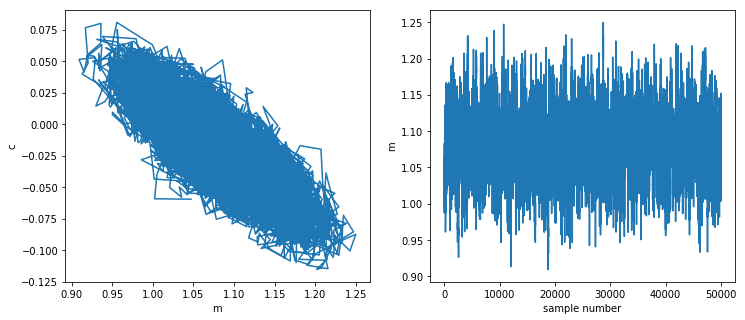

In [15]:
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
axes[0].plot(samples[:, 0], samples[:, 1])
axes[0].set_xlabel(par_names_nv[0])
axes[0].set_ylabel(par_names_nv[1])
axes[1].plot(samples[:, 0])
axes[1].set_xlabel('sample number')
axes[1].set_ylabel(par_names_nv[0])

Now let's generate some marginalized parameter posteriors (by simply discarding all samples of the latent parameters) using DFM's [`corner`](https://corner.readthedocs.io/en/latest/) package.

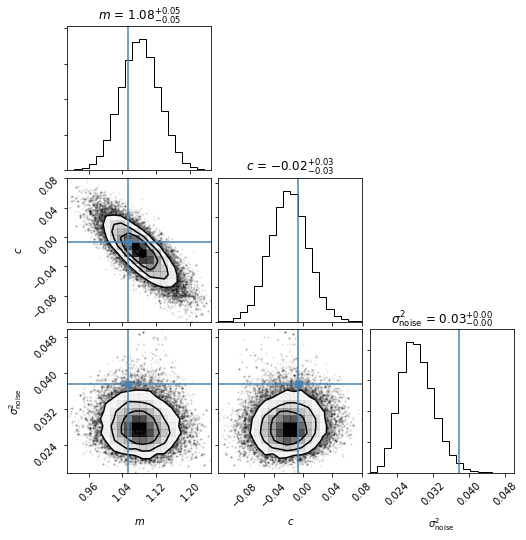

In [16]:
import corner
n_burnin = 100
final_samples = samples[n_burnin:, :]
par_names_nv_co = ['$' + par_name + '$' for par_name in par_names_nv]
fig = corner.corner(final_samples, labels=par_names_nv_co, show_titles=True, truths=pars)

There are many ways to play around with this simple sampler. Let's do a quick demonstration of the importance of the proposal distribution. For our chosen proposal, the covariance matrix tells the sampler how to try stepping around the posterior. The efficiency of this process strongly depends on how closely the proposal distribution matches the target posterior.

Try out a couple of other choices for the proposal--one larger and one smaller than the current value--and see how the sampler performs. Plotting both the 2D samples and the slope trace plot will help us investigate the sampler's behaviour.

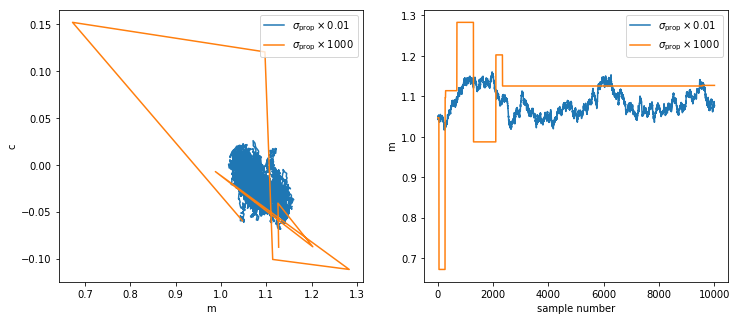

In [17]:
n_samples = 10000
mult = np.array([0.01, 1000.0])
fig, axes = mp.subplots(1, 2, figsize=(12, 5))
for i in range(2):
    prop_cov_i = prop_cov * mult[i]
    npr.seed(1234)
    samples, ln_posts = mh_sampler(n_samples, x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                   shape_var_noise, scale_var_noise, prop_cov_i)
    axes[0].plot(samples[:, 0], samples[:, 1], label=r'$\sigma_{\rm prop}\times$'+'{:g}'.format(mult[i]))
    axes[1].plot(samples[:, 0], label=r'$\sigma_{\rm prop}\times$'+'{:g}'.format(mult[i]))
axes[0].set_xlabel(par_names_nv[0])
axes[0].set_ylabel(par_names_nv[1])
axes[0].legend(loc='upper right')
axes[1].set_xlabel('sample number')
axes[1].set_ylabel(par_names_nv[0])
axes[1].legend(loc='upper right')

If the proposal $\sigma$ is too small, the sampler makes very small steps around the posterior, producing highly correlated samples. If $\sigma$ is too large, the sampler rejects most proposals, remaining stationary most of the time. In both cases the sampler is inefficient, taking an unnecessarily large number of samples to explore the posterior. Tuning the proposal is therefore an integral part of the MH algorithm.

## Task 4

Having to tune a large number of parameters to make your sampler efficient is annoying. [emcee](https://emcee.readthedocs.io/en/stable/) implements an affine-invariant ensemble sampling algorithm that reduces the tuning needed for efficient exploration of an $N$-dimensional posterior from $\sim N^2/2$ parameters (i.e., a covariance matrix) to just 2, thereby enabling sampling in larger numbers of dimensions than Metropolis-Hastings. It also has a particularly simple interface, whereby the user only has to specify a function calculating the log-posterior (in exactly the format we've developed above, hooray!), a number of walkers to use and an initial position for each walker (which we can draw from the prior). Plug our problem into emcee: it's dead easy.

In [18]:
# setup
import emcee
n_walkers = 50
n_dim = len(pars)

# define an initial position in parameter space for each walker: just draw from sample_prior_nv()
init_pos = np.zeros((n_walkers, n_dim))
for i in range(n_walkers):
    init_pos[i, :] = sample_prior_nv(mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                                     scale_var_noise)

# create an emcee sampler. args here is a list of arguments required by the log-posterior function:
# everything but the sampled parameter values
args = [x, y, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise]
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_post_nv, args=args)

# sample. we do two runs here: one short to burn the sampler in, and one long to explore the posterior
pos, prob, state = sampler.run_mcmc(init_pos, 200)
print('* burned in')
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
print('* sampling complete')

* burned in
* sampling complete


Now we can plot the samples we've generated and compare to the Metropolis-Hastings results above.

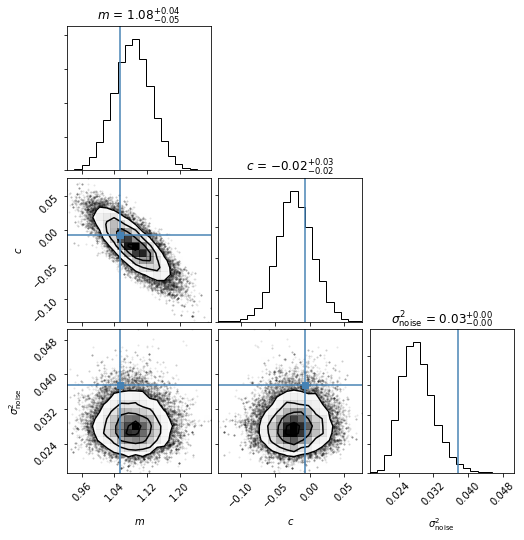

In [19]:
flat_samples = sampler.flatchain
fig = corner.corner(flat_samples, labels=par_names_nv_co, show_titles=True, truths=pars)

## Task 5

Move on to the problem in which there is uncertainty in the measurement positions. This a significantly harder inference problem, as we must infer the measurement positions as well as the regression parameters. First, re-write the simulator to generate uncertain measurement positions. Consider a (much!) smaller dataset so as to not overwhelm emcee.

In [20]:
# prior settings
n_x = 10
mu_x = np.linspace(0.0, 1.0, n_x)
sig_x = 0.025
sig_noise_x = 0.05

# draw sample from parameter prior: true x positions, slope, intercept & noise variance
def prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                     scale_var_noise):
    
    n_x = len(mu_x)
    pars = np.zeros(n_x + 3)
    pars[0: n_x] = npr.normal(mu_x, sig_x, n_x)
    pars[n_x] = npr.normal(mu_slope, sig_slope)
    pars[n_x + 1] = npr.normal(mu_intcpt, sig_intcpt)
    pars[n_x + 2] = 1.0 / npr.gamma(shape_var_noise, 1.0 / scale_var_noise)
    
    return pars

# generate noisy data given parameters: noisy measurement positions and measurements
def sample_data_nvx(pars, sig_noise_x):
    
    # dimension output array
    n_x = len(pars) - 3
    y = np.zeros(2 * n_x)
    
    # add noise to true measurement positions (pars[0: n_x])
    y[0: n_x] = npr.normal(pars[0: n_x], sig_noise_x, n_x)
    
    # generate noisy measurements
    y[n_x:] = pars[n_x] * pars[0: n_x] + pars[n_x + 1] + npr.normal(0.0, np.sqrt(pars[n_x + 2]), n_x)
    
    return y

# more advanced simulator function: noisy measurements at known locations with unknown noise variance
def simulator_nvx(mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                  shape_var_noise, scale_var_noise):
    
    # draw parameters from prior
    pars = prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, \
                            scale_var_noise)
    
    # generate data
    y = sample_data_nvx(pars, sig_noise_x)
    
    return [pars, y]

As the model is more complex I've not plotted all of the prior draws and noise histograms as before. Feel free to plot them if desired. For now, draw a single test dataset.

Text(0,0.5,'$y$')

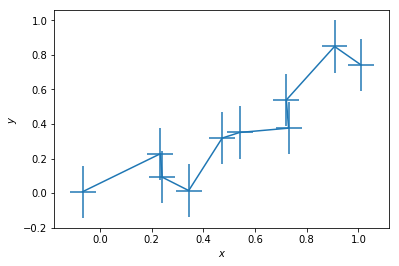

In [21]:
pars_nvx, y_nvx = simulator_nvx(mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                shape_var_noise, scale_var_noise)
mp.errorbar(y_nvx[0: n_x], y_nvx[n_x:], yerr=np.sqrt(pars_nvx[n_x + 2]), xerr=sig_noise_x)
mp.xlabel('$x$')
mp.ylabel('$y$')

Now make the changes required for inference with emcee...

In [22]:
def ln_like_nvx(pars_x, pars_reg, y_x, y_reg, sig_noise_x):
    
    delta = y - (pars[0] * x + pars[1])
    cinv = np.diag(np.ones(len(x)) / pars[2])
    ln_like_y = -0.5 * np.dot(np.dot(delta, cinv), delta)
    ln_sqrt_det = -0.5 * len(x) * np.log(pars[2])
    ln_like_x = -0.5 * np.sum(((pars_x - y_x) / sig_noise_x) ** 2)
    
    return ln_like_y + ln_sqrt_det + ln_like_x

def ln_prior_nvx(pars_x, pars_reg, mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                 shape_var_noise, scale_var_noise):
    
    ln_prior_reg = -0.5 * (((pars_reg[0] - mu_slope) / sig_slope) ** 2 + \
                           ((pars_reg[1] - mu_intcpt) / sig_intcpt) ** 2)
    ln_prior_noise = (-shape_var_noise - 1.0) * np.log(pars_reg[2]) - scale_var_noise / pars_reg[2]
    ln_prior_x = -0.5 * np.sum(((pars_x - mu_x) / sig_x) ** 2)
    
    return ln_prior_reg + ln_prior_noise + ln_prior_x

def ln_post_nvx(pars, y, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                shape_var_noise, scale_var_noise):
    
    # split parameters and observations
    n_pos = len(mu_x)
    pars_x = pars[0: n_pos]
    pars_reg = pars[n_pos:]
    y_x = y[0: n_pos]
    y_reg = y[n_pos:]
    
    # proceed only if variance is positive
    if pars_reg[2] <= 0.0:
        return -1.0e90
    else:
        return ln_like_nvx(pars_x, pars_reg, y_x, y_reg, sig_noise_x) + \
               ln_prior_nvx(pars_x, pars_reg, mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                            shape_var_noise, scale_var_noise)

... and see what happens when run on our data!

In [23]:
# setup
n_dim = n_x + 3

# define an initial position in parameter space for each walker: just draw from sample_prior_nv()
init_pos = np.zeros((n_walkers, n_dim))
for i in range(n_walkers):
    init_pos[i, :] = prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                      shape_var_noise, scale_var_noise)
    
# create an emcee sampler. args here is a list of arguments required by the log-posterior function:
# everything but the sampled parameter values
args = [y_nvx, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise]
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_post_nvx, args=args)

# sample. we do two runs here: one short to burn the sampler in, and one long to explore the posterior
pos, prob, state = sampler.run_mcmc(init_pos, 200)
print('* burned in')
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
print('* sampling complete')

* burned in
* sampling complete


MEGA PLOT INCOMING.

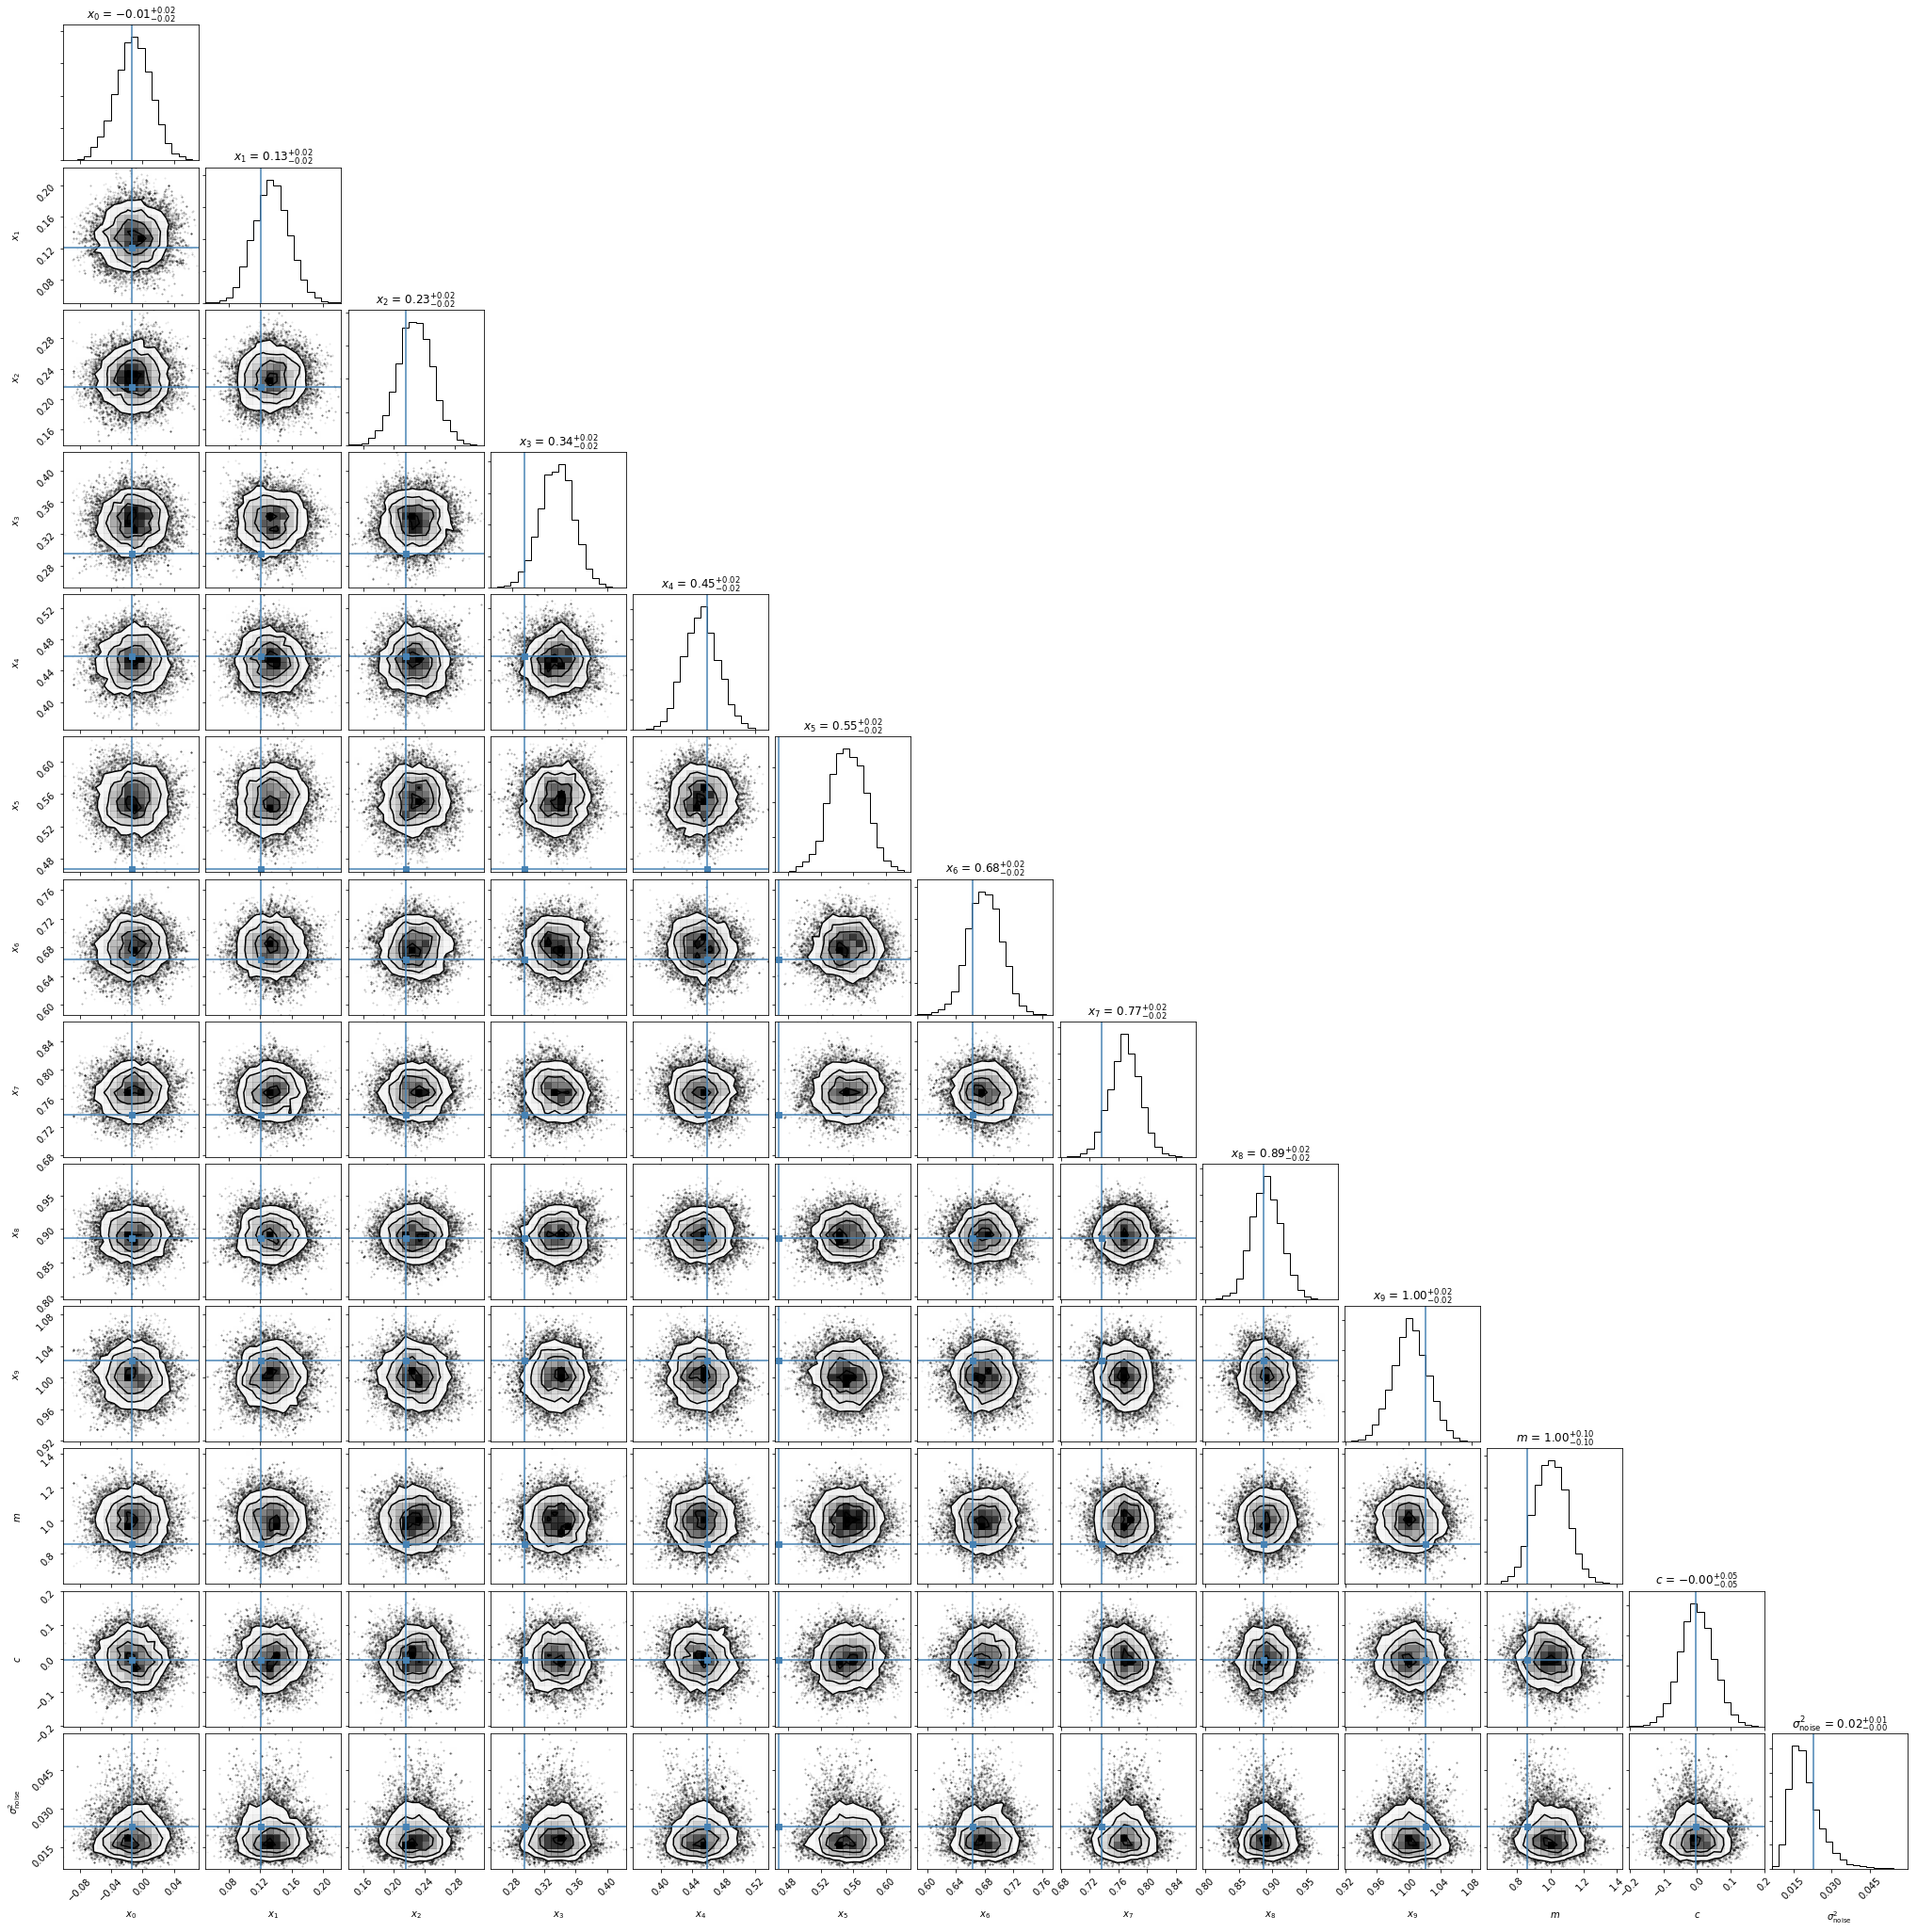

In [24]:
par_names_nvx = ['x_{:d}'.format(i) for i in range(n_x)] + par_names_nv
par_names_nvx_co = ['$' + par_name + '$' for par_name in par_names_nvx]
flat_samples = sampler.flatchain
fig = corner.corner(flat_samples, labels=par_names_nvx_co, show_titles=True, truths=pars_nvx)

There aren't many problems in Astrophysics with 10 datapoints. Let's do that again with more data to see what happens...

* burned in
* sampling complete


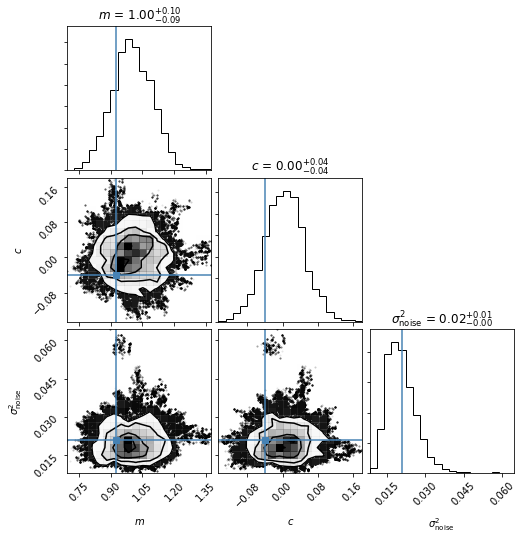

In [25]:
n_x = 200
n_walkers = 420
mu_x = np.linspace(0.0, 1.0, n_x)
pars_nvx, y_nvx = simulator_nvx(mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                shape_var_noise, scale_var_noise)
n_dim = n_x + 3
init_pos = np.zeros((n_walkers, n_dim))
for i in range(n_walkers):
    init_pos[i, :] = prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                      shape_var_noise, scale_var_noise)
args = [y_nvx, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, shape_var_noise, scale_var_noise]
sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_post_nvx, args=args)
pos, prob, state = sampler.run_mcmc(init_pos, 200)
print('* burned in')
sampler.reset()
pos, prob, state = sampler.run_mcmc(pos, 1000, rstate0=state)
print('* sampling complete')
flat_samples = sampler.flatchain
fig = corner.corner(flat_samples[:, n_x:], labels=par_names_nv_co, show_titles=True, truths=pars_nvx[n_x:])

Note that the walltime is not ridiculous by any means (as the posterior is very Gaussian in most dimensions), but the quality of the sampling is breaking down.

## Task 6

Below I've written all but one of the conditional distributions required to infer the parameters of our most complicated model via Gibbs sampling. Please code up the remaining conditional, using the results you've derived on paper. 

In [26]:
def sample_x(n_x, pars, y, sig_noise_x, mu_x, sig_x):
    
    sample = np.zeros(n_x)
    for i in range(n_x):
        x_var = 1.0 / (1.0 / sig_x ** 2 + pars[n_x] ** 2 / pars[n_x + 2] + 1.0 / sig_noise_x ** 2)
        x_mean = (mu_x[i] / sig_x ** 2 + \
                  pars[n_x] ** 2 / pars[n_x + 2] * (y[n_x + i] - pars[n_x + 1]) / pars[n_x] + \
                  y[i] / sig_noise_x ** 2) * x_var
        sample[i] = npr.normal(x_mean, np.sqrt(x_var))
    
    return sample

def sample_slope(n_x, pars, y, mu_slope, sig_slope):
    
    slope_var = 1.0 / (np.sum(pars[0: n_x] ** 2 / pars[n_x + 2]) + 1.0 / sig_slope ** 2)
    slope_mean = (np.sum(pars[0: n_x] ** 2 / pars[n_x + 2] * (y[n_x:] - pars[n_x + 1]) / pars[0: n_x]) + \
                  mu_slope / sig_slope ** 2) * slope_var
    sample = npr.normal(slope_mean, np.sqrt(slope_var))
    
    return sample

def sample_intcpt(n_x, pars, y, mu_intcpt, sig_intcpt):
    
    intcpt_var = 1.0 / (n_x / pars[n_x + 2] + 1.0 / sig_intcpt ** 2)
    intcpt_mean = (np.sum(1.0 / pars[n_x + 2] * (y[n_x:] - pars[n_x] * pars[0: n_x])) + \
                  mu_intcpt / sig_intcpt ** 2) * intcpt_var
    sample = npr.normal(intcpt_mean, np.sqrt(intcpt_var))
    
    return sample

def sample_noise_var(n_x, pars, y, shape_var_noise, scale_var_noise):
    
    new_shape = shape_var_noise + float(n_x) / 2.0
    new_scale = scale_var_noise + 0.5 * np.sum((y[n_x:] - pars[n_x] * pars[0: n_x] - pars[n_x + 1]) ** 2)
    sample = 1.0 / npr.gamma(new_shape, 1.0 / new_scale)
    
    return sample

Now write the Gibbs sampler!

In [27]:
def gibbs_sample(y, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                 shape_var_noise, scale_var_noise):
    
    # storage
    n_x = len(mu_x)
    n_par = n_x + 3
    samples = np.zeros((n_par, n_samples))
    
    # initialize sampler
    samples[:, 0] = prior_sample_nvx(mu_x, sig_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                                     shape_var_noise, scale_var_noise)
    
    # sample!
    sample = samples[:, 0]
    for i in range(1, n_samples):
        
        # sample x
        sample[0: n_x] = sample_x(n_x, sample, y, sig_noise_x, mu_x, sig_x)
        
        # sample slope
        sample[n_x] = sample_slope(n_x, sample, y, mu_slope, sig_slope)
        
        # sample intercept
        sample[n_x + 1] = sample_intcpt(n_x, sample, y, mu_intcpt, sig_intcpt)
            
        # sample noise variance
        sample[n_x + 2] = sample_noise_var(n_x, sample, y, shape_var_noise, scale_var_noise)
        
        # store new state
        samples[:, i] = sample
        
    return samples

Now let's sample, setting aside the first half of the samples as warmup.

In [28]:
n_samples = 10000
all_samples = gibbs_sample(y_nvx, mu_x, sig_x, sig_noise_x, mu_slope, sig_slope, mu_intcpt, sig_intcpt, \
                           shape_var_noise, scale_var_noise)
n_warmup = int(n_samples / 2)
g_samples = all_samples[:, n_warmup:]

Let's make sure that the noise variance is being inferred as expected. First, generate a trace plot of the samples, overlaying the ground truth. Then print out the mean and standard deviation of the marginalized absolute magnitude posterior. Recall that marginalizing is as simple as throwing away the samples of all other parameters.

Truth 0.0211; inferred 0.0202 +/- 0.0020


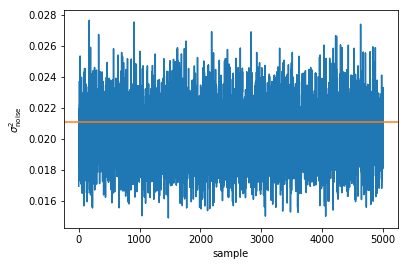

In [29]:
mp.plot(g_samples[n_x + 2, :])
mp.axhline(pars_nvx[n_x + 2], color='C1')
mp.xlabel('sample')
mp.ylabel(par_names_nv_co[2])
print('Truth {:6.4f}; inferred {:6.4f} +/- {:6.4f}'.format(pars_nvx[n_x + 2], \
                                                           np.mean(g_samples[n_x + 2, :]), \
                                                           np.std(g_samples[n_x + 2, :])))

Now let's generate some marginalized parameter posteriors (by simply discarding all samples of the latent parameters) using DFM's [`corner`](https://corner.readthedocs.io/en/latest/) package.

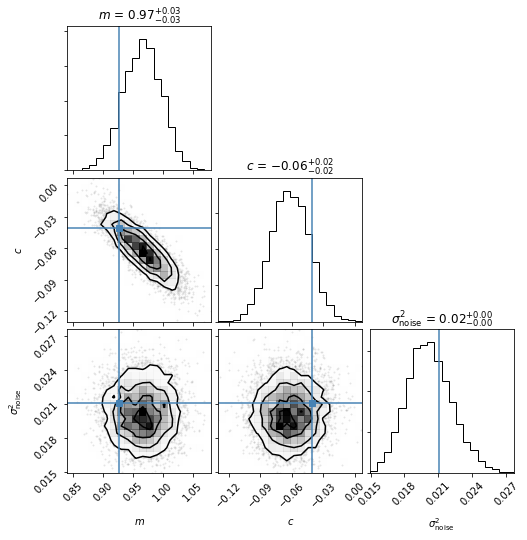

In [30]:
import corner
samples = g_samples[n_x:, :]
fig = corner.corner(samples.T, labels=par_names_nv_co,
                    show_titles=True, truths=pars_nvx[n_x:])

## Task 7

The final task is to write a [Stan model](https://pystan.readthedocs.io/en/latest/getting_started.html) to infer the parameters of our linear regression problem. I've coded up the other two blocks required (`data` and `parameters`), so all that is required is for you to write the joint posterior (factorized into its individual components) in Stan's sampling-statement-based syntax. Essentially all you need are Gaussian sampling statements (`slope ~ normal(mu_slope, sig_slope);`) and for loops (`for(i in 1: n_x){...}`). A full list of the functions you might need can be found [here](https://mc-stan.org/docs/2_18/functions-reference/inverse-gamma-distribution.html).

When you evaluate the cell below, Stan will translate your model into `c++` code and compile it. It's slow. We will then pickle the compiled model so you can re-use it rapidly without recompiling. To do so, please set `recompile = False` in the notebook.

In [31]:
# modules
import sys
import pystan as ps
import pickle

# stan model code
stan_code = """
data {
    int<lower=0> n_x;
    real y[2 * n_x];
    real mu_x[n_x];
    real sig_x;
    real sig_noise_x;
    real mu_slope;
    real sig_slope;
    real mu_intcpt;
    real sig_intcpt;
    real shape_var_noise;
    real scale_var_noise;
}
parameters {
    real x[n_x];
    real slope;
    real intcpt;
    real var_noise;
}
model {
    // priors
    for(i in 1: n_x){
        x[i] ~ normal(mu_x[i], sig_x);
    }
    slope ~ normal(mu_slope, sig_slope);
    intcpt ~ normal(mu_intcpt, sig_intcpt);
    var_noise ~ inv_gamma(shape_var_noise, scale_var_noise);
    
    // likelihoods
    for(i in 1: n_x){
        y[i] ~ normal(x[i], sig_noise_x);
    }
    for(i in 1: n_x){
        y[n_x + i] ~ normal(slope * x[i] + intcpt, sqrt(var_noise));
    }
}
"""

# compilation
recompile = True
pkl_fname = 'bhms_stan_model_v{:d}p{:d}p{:d}.pkl'.format(sys.version_info[0], \
                                                         sys.version_info[1], \
                                                         sys.version_info[2])
if recompile:
    stan_model = ps.StanModel(model_code=stan_code)
    with open(pkl_fname, 'wb') as f:
        pickle.dump(stan_model, f)
else:
    try:
        with open(pkl_fname, 'rb') as f:
            stan_model = pickle.load(f)
    except EnvironmentError:
        print('ERROR: pickled Stan model (' + pkl_fname + ') not found. ' + \
              'Please set recompile = True')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_65649fb2c6d6893fe82ef8e7f1dd1ebd NOW.
/Users/sfeeney/Software_Packages/miniconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/sfeeney/Temp/tmp2vlp1pbm/stanfit4anon_model_65649fb2c6d6893fe82ef8e7f1dd1ebd_8247644816050999876.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Now let's sample...

In [32]:
n_samples_stan = 5000
stan_data = {'n_x': n_x, 'y': y_nvx, 'mu_x': mu_x, 'sig_x': sig_x, 'sig_noise_x': sig_noise_x, \
             'mu_slope': mu_slope, 'sig_slope': sig_slope, 'mu_intcpt': mu_intcpt, 'sig_intcpt': sig_intcpt, \
             'shape_var_noise': shape_var_noise, 'scale_var_noise': scale_var_noise}
fit = stan_model.sampling(data=stan_data, iter=n_samples_stan, chains=4)

/Users/sfeeney/Software_Packages/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


... print out Stan's posterior summary (note this is for _all_ parameters)...

In [33]:
samples = fit.extract(permuted=True)
print(fit)

Inference for Stan model: anon_model_65649fb2c6d6893fe82ef8e7f1dd1ebd.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
x[0]     -9.9e-4  2.2e-4   0.02  -0.04  -0.02-6.9e-4   0.01   0.04  10000    1.0
x[1]     -2.3e-3  2.2e-4   0.02  -0.05  -0.02-2.5e-3   0.01   0.04  10000    1.0
x[2]        0.01  2.2e-4   0.02  -0.03-9.4e-4   0.01   0.03   0.06  10000    1.0
x[3]        0.03  2.2e-4   0.02  -0.02   0.01   0.03   0.04   0.07  10000    1.0
x[4]        0.02  2.2e-4   0.02  -0.02   0.01   0.02   0.04   0.07  10000    1.0
x[5]        0.04  2.2e-4   0.02-6.0e-3   0.02   0.04   0.05   0.08  10000    1.0
x[6]        0.03  2.2e-4   0.02-8.6e-3   0.02   0.03   0.05   0.08  10000    1.0
x[7]        0.05  2.2e-4   0.02 1.9e-3   0.03   0.05   0.06   0.09  10000    1.0
x[8]        0.04  2.2e-4   0.02 1.9e-3   0.03   0.04   0.06   0.09  10000    1.0


... and plot the marginalized posterior of the non-nuisance parameters, as with the Gibbs sampler.

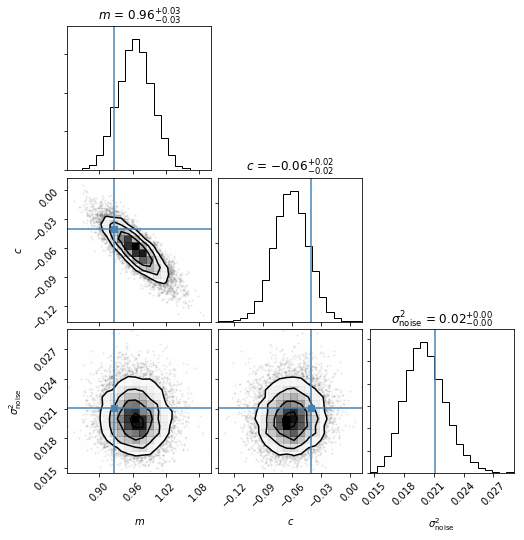

In [34]:
c_samples = np.stack((samples['slope'], samples['intcpt'], samples['var_noise']))
fig = corner.corner(c_samples.T, labels=par_names_nv_co,
                    show_titles=True, truths=pars_nvx[n_x:])

Our work here is done!